
    This Source Code Form is subject to the terms of the Mozilla Public
    License, v. 2.0. If a copy of the MPL was not distributed with this
    file, You can obtain one at http://mozilla.org/MPL/2.0/.


In [1]:
# Enable automatic module reload
%load_ext autoreload
%autoreload 2

# To ease the loading of modules
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

# Load BEACS module
from beacs.agents.beacs import BEACS, Configuration

# Load Metrics
from example.metrics.MazeMetrics import \
    _maze_metrics, \
    _how_many_peps_match_non_aliased_states, \
    _mean_reliable_classifier_specificity, \
    _when_full_knowledge_is_achieved, \
    _enhanced_effect_error

# Load Plotting Wrappers
from example.metrics.MazePlottingWrapper import \
    parse_metrics_to_df, \
    plot_performance

# Load environments
import gym
import my_mazes

# Agent - BEACS

## Common parameters

In [2]:
#Environmental Set Up
RANDOM_ATTRIBUTE_LENGTH = 0
CLASSIFIER_LENGTH = 8 + RANDOM_ATTRIBUTE_LENGTH
NUMBER_OF_POSSIBLE_ACTIONS = 8
SLIPPERY_PROB = 0.
MAZE = "MazeE2-v0"

#Exploration Set Up
NUMBER_OF_EXPLORE_TRIALS = 5000
METRICS_TRIAL_FREQUENCY_EXPLORE = 100
EPSILON = 0.8
BETA_ALP = 0.05

#Exploitation Set Up
NUMBER_OF_EXPLOIT_TRIALS_NO_RL = 500
BETA_EXPLOIT_NO_RL = 0.05
NUMBER_OF_EXPLOIT_TRIALS_RL_START = 500
BETA_EXPLOIT_RL_START = 0.05
NUMBER_OF_EXPLOIT_TRIALS_RL = 500
BETA_EXPLOIT_RL = 0.05

#RL Set Up
GAMMA = 0.95
BETA_RL = 0.05

#GA Set Up
CROSSOVER = 0.8
MUTATION = 0.3

#BEACS Set Up
DO_ZIP = True
ENABLE_PEP = True
LENGTH_OF_BEHAVIORAL_SEQUENCES = 2

## Environment - Maze

In [3]:
# Initialize environment
maze = gym.make(MAZE)
# Set up probability to do a random action
maze.env.set_prob_slippery(SLIPPERY_PROB)
# Set up random attribute length
maze.env.set_random_attribute_length(RANDOM_ATTRIBUTE_LENGTH)
# Reset it, by putting an agent into random position
maze.reset()
# Render the state in ASCII
maze.render('aliasing_human')
# Get environmental state transitions
#maze.env.get_theoritical_probabilities()


■ ■ ■ ■ ■ ■ ■ ■ ■
■ □ ■ ■ ■ ■ ■ □ ■
■ ■ ■ ■ ■ ■ ■ ■ ■
■ ■ ■ □ □ □ ■ ■ ■
■ ■ ■ □ $ □ ■ ■ ■
■ ■ ■ □ □ □ ■ ■ ■
■ ■ ■ ■ ■ ■ A ■ ■
■ □ ■ ■ ■ ■ ■ □ ■
■ ■ ■ ■ ■ ■ ■ ■ ■


## Training of BEACS - Exploration

In [4]:
%%time

cfg_explore = Configuration(
    classifier_length=CLASSIFIER_LENGTH,
    number_of_possible_actions=NUMBER_OF_POSSIBLE_ACTIONS,
    user_metrics_collector_fcn=_maze_metrics,
    metrics_trial_frequency=METRICS_TRIAL_FREQUENCY_EXPLORE,
    do_pep=ENABLE_PEP,
    beta_alp=BETA_ALP,
    beta_rl=BETA_RL,
    gamma=GAMMA,
    epsilon=EPSILON,
    u_max=CLASSIFIER_LENGTH,
    mu=MUTATION,
    chi=CROSSOVER,
    bs_max=LENGTH_OF_BEHAVIORAL_SEQUENCES
)

agent_explore = BEACS(cfg_explore)
population_explore, metrics_explore = agent_explore.explore(maze, NUMBER_OF_EXPLORE_TRIALS)

Add ('0', '0', '0', '0', '0', '0', '0', '0') in [] 

Add ('0', '0', '0', '0', '0', '1', '1', '1') in [('0', '0', '0', '0', '0', '0', '0', '0')] 

Add ('0', '0', '0', '1', '1', '1', '0', '0') in [('0', '0', '0', '0', '0', '0', '0', '0'), ('0', '0', '0', '0', '0', '1', '1', '1')] 

Add ('1', '1', '0', '0', '0', '0', '0', '1') in [('0', '0', '0', '0', '0', '0', '0', '0'), ('0', '0', '0', '0', '0', '1', '1', '1'), ('0', '0', '0', '1', '1', '1', '0', '0')] 

Add ('0', '1', '1', '1', '0', '0', '0', '0') in [('0', '0', '0', '0', '0', '0', '0', '0'), ('0', '0', '0', '0', '0', '1', '1', '1'), ('0', '0', '0', '1', '1', '1', '0', '0'), ('1', '1', '0', '0', '0', '0', '0', '1')] 

Add ('0', '0', '0', '0', '9', '0', '0', '0') in [('0', '0', '0', '0', '0', '0', '0', '0'), ('0', '0', '0', '0', '0', '1', '1', '1'), ('0', '0', '0', '1', '1', '1', '0', '0'), ('1', '1', '0', '0', '0', '0', '0', '1'), ('0', '1', '1', '1', '0', '0', '0', '0')] 

Remove ('0', '0', '0', '0', '9', '0', '0', '0') in [('0', '0',

### Performance

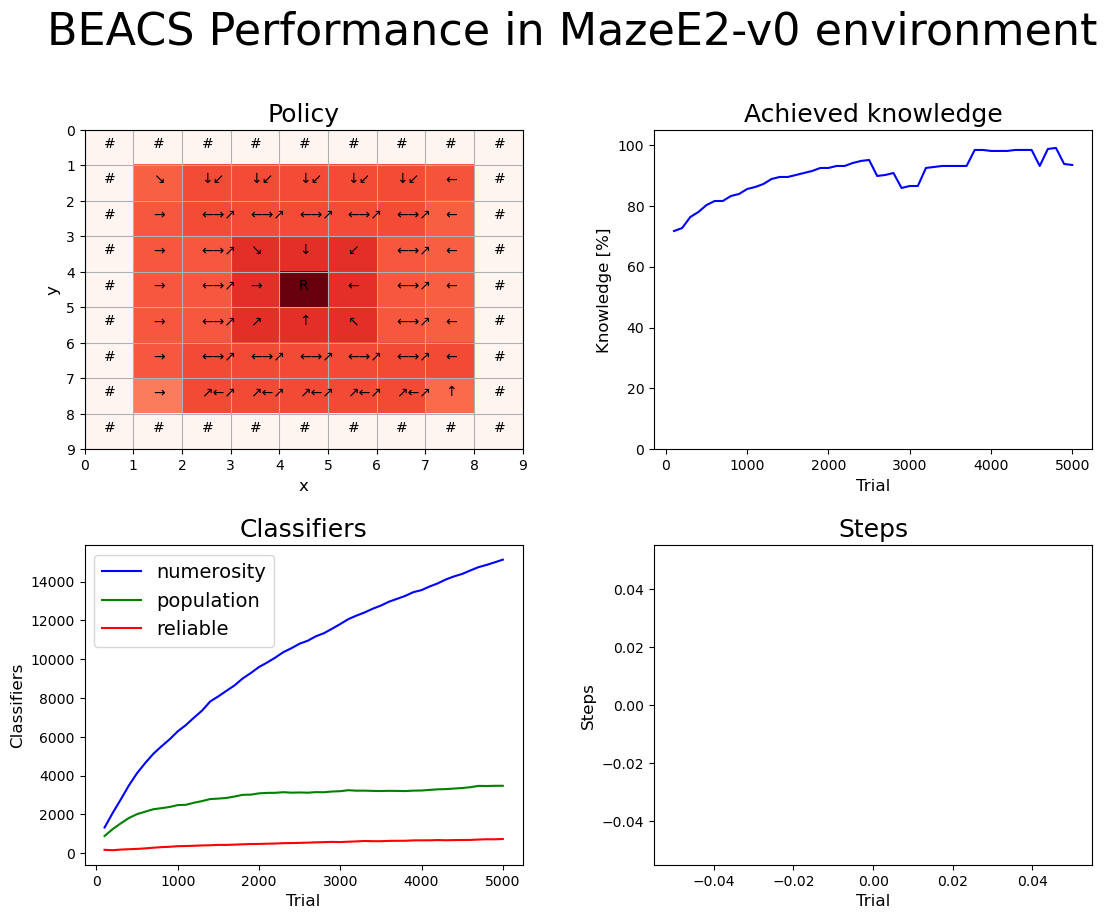

In [5]:
metrics_trial_frequency_explore = cfg_explore.metrics_trial_frequency

metrics_df = parse_metrics_to_df(metrics_explore, metrics_trial_frequency_explore, None, None)
plot_performance(agent_explore, maze, metrics_df, cfg_explore, MAZE, metrics_trial_frequency_explore, None)

In [6]:
first_trial, stable_trial, last_trial = _when_full_knowledge_is_achieved(metrics_explore)
print("Full knowledge was achieved at trials ", first_trial, ", was stable at ", stable_trial, 
        " and the last time it was achieved at ", last_trial)

print("There are ", _how_many_peps_match_non_aliased_states(population_explore, maze),
      " enhanced classifer(s) that match a non-aliased states.\n")

print(_maze_metrics(population_explore, maze))
print("Mean reliable population specifity is ",
      _mean_reliable_classifier_specificity(population_explore, maze))
pep_error = _enhanced_effect_error(population_explore, maze, CLASSIFIER_LENGTH, RANDOM_ATTRIBUTE_LENGTH)
print("Accumulated Error on PEP Probabilities :", pep_error, "%\n")

if DO_ZIP:
    agent_explore.zip_population()
    population_explore = agent_explore.get_population()

print("There are ", _how_many_peps_match_non_aliased_states(population_explore, maze),
      " enhanced classifer(s) that match a non-aliased states.\n")

print(_maze_metrics(population_explore, maze))
print("Mean reliable population specifity is ",
      _mean_reliable_classifier_specificity(population_explore, maze))
pep_error = _enhanced_effect_error(population_explore, maze, CLASSIFIER_LENGTH, RANDOM_ATTRIBUTE_LENGTH)
print("Accumulated Error on PEP Probabilities :", pep_error, "%")

Full knowledge was achieved at trials  -1 , was stable at  -1  and the last time it was achieved at  -1
There are  7  enhanced classifer(s) that match a non-aliased states.

{'knowledge': 93.42105263157895, 'population': 3478, 'numerosity': 15127, 'reliable': 737}
Mean reliable population specifity is  0.651797829036635
Accumulated Error on PEP Probabilities : 1.687347869981805 %

There are  4  enhanced classifer(s) that match a non-aliased states.

{'knowledge': 93.42105263157895, 'population': 515, 'numerosity': 5731, 'reliable': 441}
Mean reliable population specifity is  0.5651927437641724
Accumulated Error on PEP Probabilities : 1.1611632867523596 %


In [7]:
population_explore.sort(key=lambda cl: -cl.fitness)
population_explore_to_display = [cl for cl in population_explore]
for cl in population_explore_to_display:
    print(cl)
    print("\n")

###9#### 3 None (###0####:#667) (empty [True, True, True, True, True, True, True, True])
q: 1.0    ra: 1e+03  rb: 1e+03  ir: 1e+03  f: 1e+03  err: 0.0002867
exp: 616   num: 17 ee: False PAI_state: 
tga: 178367 tbseq: 178364 talp: 178367 tav: 282.6  



####9### 4 None (####0###:#637) (empty [True, True, True, True, True, True, True, True])
q: 1.0    ra: 1e+03  rb: 1e+03  ir: 1e+03  f: 1e+03  err: 0.0009458
exp: 584   num: 16 ee: False PAI_state: 
tga: 178549 tbseq: 174562 talp: 178549 tav: 261.0  



#####9## 5 None (#####0##:#653) (empty [True, True, True, True, True, True, True, True])
q: 1.0    ra: 1e+03  rb: 1e+03  ir: 1e+03  f: 1e+03  err: 0.0003787
exp: 605   num: 17 ee: False PAI_state: 
tga: 178529 tbseq: 172497 talp: 178529 tav: 478.3  



##9##### 2 None (##0#####:#426) (empty [True, True, True, True, True, True, True, True])
q: 1.0    ra: 1e+03  rb: 999.9  ir: 1e+03  f: 1e+03  err: 0.1652
exp: 377   num: 19 ee: False PAI_state: 
tga: 177698 tbseq: 2     talp: 177698 tav: 608




###90### 6 [1, 0] (11#0###1:#28) (empty [True, True, True, True, True, True, True, True])
q: 0.9595 ra: 416.4  rb: 401.8  ir: 0.0    f: 385.5  err: 430.8 
exp: 28    num: 20 ee: False PAI_state: 00000000
tga: 175140 tbseq: 20601 talp: 175140 tav: 5.364e+03 



#0#00#1# 4 [2, 0] (#####000:#33) (empty [True, True, True, True, True, True, True, True])
q: 0.917  ra: 418.6  rb: 451.9  ir: 0.0    f: 383.9  err: 398.9 
exp: 33    num: 20 ee: False PAI_state: 00000111
tga: 176182 tbseq: 61593 talp: 176182 tav: 3.551e+03 



00000009 3 [0] (#######0:#29) (empty [True, True, True, True, True, True, True, True])
q: 0.9568 ra: 515.6  rb: 283.1  ir: 0.0    f: 382.1  err: 360.4 
exp: 27    num: 14 ee: False PAI_state: 00000000
tga: 174209 tbseq: 50007 talp: 174209 tav: 4.462e+03 



####9#00 6 [6] (####0###:#38) (empty [True, True, True, True, True, True, True, True])
q: 0.9363 ra: 412.0  rb: 403.9  ir: 0.0    f: 382.0  err: 389.9 
exp: 37    num: 20 ee: False PAI_state: 00000000
tga: 174419 tbse

In [8]:
agent_explore.get_pai_states_memory()

[('0', '0', '0', '0', '0', '0', '0', '0'),
 ('0', '0', '0', '0', '0', '1', '1', '1'),
 ('0', '0', '0', '1', '1', '1', '0', '0'),
 ('1', '1', '0', '0', '0', '0', '0', '1'),
 ('0', '1', '1', '1', '0', '0', '0', '0'),
 ('9', '0', '0', '0', '0', '0', '0', '0'),
 ('0', '0', '0', '0', '9', '0', '0', '0')]

## Training of BEACS - Exploitation

In [9]:
%%time

cfg_exploit_no_rl = Configuration(
    classifier_length=CLASSIFIER_LENGTH,
    number_of_possible_actions=NUMBER_OF_POSSIBLE_ACTIONS,
    user_metrics_collector_fcn=_maze_metrics,
    metrics_trial_frequency=1,
    beta_rl=BETA_EXPLOIT_NO_RL,
    gamma=GAMMA,
    epsilon=0.2
)

agent_exploit_no_rl = BEACS(cfg_exploit_no_rl, population_explore)
population_exploit_no_rl, metrics_exploit_no_rl = agent_exploit_no_rl.exploit(maze, NUMBER_OF_EXPLOIT_TRIALS_NO_RL)

CPU times: user 25.4 s, sys: 229 ms, total: 25.6 s
Wall time: 26.4 s


In [10]:
%%time

cfg_exploit_rl_start = Configuration(
    classifier_length=CLASSIFIER_LENGTH,
    number_of_possible_actions=NUMBER_OF_POSSIBLE_ACTIONS,
    user_metrics_collector_fcn=_maze_metrics,
    metrics_trial_frequency=1,
    beta_rl=BETA_EXPLOIT_RL_START,
    gamma=GAMMA,
    epsilon=0.0
)

agent_exploit_rl_start = BEACS(cfg_exploit_rl_start, population_exploit_no_rl)
population_exploit_rl_start, metrics_exploit_rl_start = agent_exploit_rl_start.exploit(maze, NUMBER_OF_EXPLOIT_TRIALS_RL_START)

CPU times: user 26.8 s, sys: 253 ms, total: 27 s
Wall time: 29.1 s


In [11]:
%%time

cfg_exploit_rl = Configuration(
    classifier_length=CLASSIFIER_LENGTH,
    number_of_possible_actions=NUMBER_OF_POSSIBLE_ACTIONS,
    user_metrics_collector_fcn=_maze_metrics,
    metrics_trial_frequency=1,
    beta_rl=BETA_EXPLOIT_RL,
    gamma=GAMMA,
    epsilon=0.0,
)

agent_exploit_rl = BEACS(cfg_exploit_rl, population_exploit_rl_start)
population_exploit_rl, metrics_exploit_rl = agent_exploit_rl.exploit(maze, NUMBER_OF_EXPLOIT_TRIALS_RL)

CPU times: user 21.4 s, sys: 148 ms, total: 21.5 s
Wall time: 22 s


### Performance

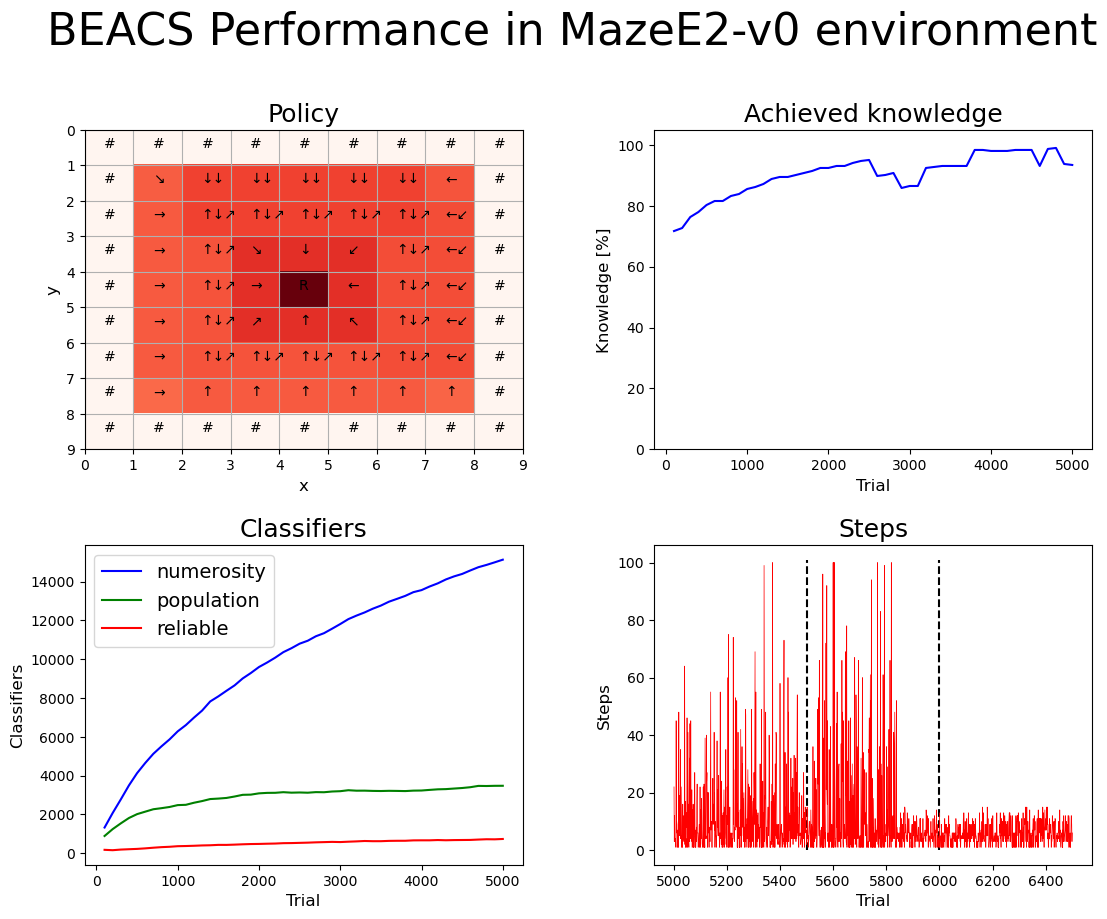

In [12]:
metrics_trial_frequency_explore = cfg_explore.metrics_trial_frequency
metrics_trial_frequency_exploit = 1

metrics_exploit = metrics_exploit_no_rl.copy()
for idx, item in enumerate(metrics_exploit_rl_start):
    tmp = item.copy()
    tmp['trial'] += NUMBER_OF_EXPLOIT_TRIALS_NO_RL
    metrics_exploit.append(tmp)
for idx, item in enumerate(metrics_exploit_rl):
    tmp = item.copy()
    tmp['trial'] += NUMBER_OF_EXPLOIT_TRIALS_NO_RL + NUMBER_OF_EXPLOIT_TRIALS_RL_START
    metrics_exploit.append(tmp)

metrics_df = parse_metrics_to_df(metrics_explore, metrics_trial_frequency_explore, metrics_exploit, metrics_trial_frequency_exploit)
plot_performance(agent_exploit_rl, maze, metrics_df, cfg_exploit_rl, MAZE, metrics_trial_frequency_explore, [NUMBER_OF_EXPLOIT_TRIALS_NO_RL,NUMBER_OF_EXPLOIT_TRIALS_RL_START,NUMBER_OF_EXPLOIT_TRIALS_RL])

In [13]:
avg_step_explore = 0
for trial in metrics_explore:
    avg_step_explore += trial['steps_in_trial']
avg_step_explore /= NUMBER_OF_EXPLORE_TRIALS / metrics_trial_frequency_explore
print("Average number of steps to solve the maze is ",avg_step_explore,
      " for a total of ", NUMBER_OF_EXPLORE_TRIALS, " trials in EXPLORATION")

avg_step_exploit_no_rl = 0
for trial in metrics_exploit_no_rl:
    avg_step_exploit_no_rl += trial['steps_in_trial']
avg_step_exploit_no_rl /= NUMBER_OF_EXPLOIT_TRIALS_NO_RL
print("Average number of steps to solve the maze is ",avg_step_exploit_no_rl,
      " for a total of ", NUMBER_OF_EXPLOIT_TRIALS_NO_RL, " trials in EXPLOITATION without Reinforcement Module")

avg_step_exploit_rl_start = 0
for trial in metrics_exploit_rl_start:
    avg_step_exploit_rl_start += trial['steps_in_trial']
avg_step_exploit_rl_start /= NUMBER_OF_EXPLOIT_TRIALS_RL_START
print("Average number of steps to solve the maze is ",avg_step_exploit_rl_start,
      " for a total of ", NUMBER_OF_EXPLOIT_TRIALS_RL_START, " trials in EXPLOITATION starting Reinforcement Module")

avg_step_exploit_rl = 0
for trial in metrics_exploit_rl:
    avg_step_exploit_rl += trial['steps_in_trial']
avg_step_exploit_rl /= NUMBER_OF_EXPLOIT_TRIALS_RL
print("Average number of steps to solve the maze is ",avg_step_exploit_rl,
      " for a total of ", NUMBER_OF_EXPLOIT_TRIALS_RL, " trials in EXPLOITATION with Reinforcement Module")

print(_maze_metrics(population_explore, maze))
print(_maze_metrics(population_exploit_no_rl, maze))
print(_maze_metrics(population_exploit_rl_start, maze))
print(_maze_metrics(population_exploit_rl, maze))

Average number of steps to solve the maze is  36.38  for a total of  5000  trials in EXPLORATION
Average number of steps to solve the maze is  12.23  for a total of  500  trials in EXPLOITATION without Reinforcement Module
Average number of steps to solve the maze is  12.588  for a total of  500  trials in EXPLOITATION starting Reinforcement Module
Average number of steps to solve the maze is  5.842  for a total of  500  trials in EXPLOITATION with Reinforcement Module
{'knowledge': 93.42105263157895, 'population': 515, 'numerosity': 5731, 'reliable': 441}
{'knowledge': 93.42105263157895, 'population': 515, 'numerosity': 5731, 'reliable': 441}
{'knowledge': 93.42105263157895, 'population': 515, 'numerosity': 5731, 'reliable': 441}
{'knowledge': 93.42105263157895, 'population': 515, 'numerosity': 5731, 'reliable': 441}


In [14]:
population_exploit_rl.sort(key=lambda cl: -cl.fitness)
population_exploit_rl_to_display = [cl for cl in population_exploit_rl
    if cl.behavioral_sequence]
print(len(population_exploit_rl_to_display))
print("\n")
for cl in population_exploit_rl_to_display:
    print(cl)
    print("\n")

309


#10#0001 4 [4] (00#####0:#1039, 00##9##0:#554, 00###9#0:#548, 00#9###0:#576) (empty [True, True, True, False, False, False, True, True])
q: 1.0    ra: 900.2  rb: 919.8  ir: 0.0    f: 910.0  err: 58.92 
exp: 2698  num: 20 ee: False PAI_state: 00000000
tga: 178418 tbseq: 7951  talp: 178486 tav: 54.7   



011100#0 6 [5] (#000###9:#37, #000#9##:#51, #000##9#:#21) (01110000 [True, True, True, True, True, False, False, False])
q: 0.935  ra: 918.2  rb: 927.2  ir: 0.0    f: 862.7  err: 45.5  
exp: 74    num: 1 ee: True PAI_state: 00000000
tga: 173030 tbseq: 83926 talp: 173030 tav: 1.281e+03 



00000000 0 [4, 1] (11#####1:#66, 1111###1:#12, ########:#26, #111####:#38, #9######:#5) (00000000 [False, False, False, False, True, True, True, False])
q: 1.0    ra: 862.2  rb: 838.2  ir: 0.0    f: 838.2  err: 48.4  
exp: 119   num: 3 ee: True PAI_state: 11000001
tga: 177958 tbseq: 77741 talp: 177958 tav: 851.1  



#10##001 4 [5] (00###9#0:#46, 00##9##0:#68, 00#9###0:#50) (11000001 [True, True,